# Feature Enginering Notebook

Python scripts for extract valuable features for the further modelling from the articles title and text.

Table of Content:
* **1. Import required packages**
* **2. Import files**
* **3. Follow up text removal**
* **4. Exploratory Analysis**
* **5. Feature Engineering**
* 5.1 Extract information from the title 
* *5.1.1 Word count of the titles*
* *5.1.2 Average word length of the title*
* *5.1.3 Count of exclamation mark in the title*
* *5.1.4 Count of question mark in the title*
* *5.1.5 Count of stop words in the title*
* *5.1.6 Count of capital words in the title*
* *5.1.7 Count of numeric values in the title*
* 5.2 Extract information from the article
* *5.2.1 Word count of the text*
* *5.2.2 Average word length of the text*
* *5.2.3 Count of question mark in the text*
* *5.2.4 Count of exclamation mark in the text*
* *5.2.5 Count of stop words in the text*
* *5.2.6 Count of capital words in the text*
* *5.2.7 Count of numeric values in the text*
* **6. More data cleanings for the creation of NLP based variables**
* **7. Create NLP based features**
* *7.1 Title tokenization*
* *7.2 Text tokenization*
* *7.3 Title lemmatization*
* *7.4 Text lemmatization*
* *7.5 Part of Speach Tagging (PoS)*
* 7.5.1 PoS on title
* 7.5.2 PoS on text
* *7.6 Create normalized features*
* **8. Check the list of created features**
* **9. Named Entity Recognition (Ner)**
* *9.1 Create the NER dictionary for the titles*
* 9.1.1 Create the Person list for each document
* 9.1.2 Create the Organization list for each document
* 9.1.3 Create the Location list for each document
* *9.2 Create the NER dictionary for the texts*
* 9.2.1 Create the Person list for each document
* 9.2.2 Create the Organization list for each document
* 9.2.3 Create the Location list for each document
* **10. Sentiment Analysis**
* *10.1 Polarity Analysis*
* 10.1.1 Polarity analysis on title lemmas
* 10.1.2 Polarity analysis on text lemmas
* **11. Difference from global mean variables**
* **12. Save the created dataframe**

### 1. Import required packages

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import re 
from datetime import datetime
from itertools import combinations

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn options
plt.figure(figsize=(15,8))

sns.set(style="whitegrid")

<Figure size 1080x576 with 0 Axes>

In [2]:
# NLP based packages:
import spacy
import hu_core_ud_lg as hu
nlp = hu.load()

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

C:\Users\molna\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'hu_core_ud_lg' (0.3.1) requires spaCy v2.1 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
import warnings
warnings.filterwarnings('ignore')

### 2. Import files

Import the merged fake news and mainstream news dataframe

In [4]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_base.pkl')

In [32]:
abt_covid.head()

,title,date,text,source,dezinf
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,2020-01-21,A vpnMentor biztonságtechnikai kutatói 875 ez...,index.hu,0
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,2020-01-21,Újabb kiberbiztonsági probléma Ukrajnában: a ...,index.hu,0
"""132""",Kell-e rettegnünk az új kínai tüdőgyulladástól?,2020-01-21,"Bár egy rövid ideig úgy tűnt, hogy a kínaiakna...",index.hu,0
"""135""",Hamarosan bejelenthetik a halálos kínai tüdőgy...,2020-01-21,Szövetségi források szerint helyi idő szerint...,index.hu,0
"""141""","Schobert: Roppant büszke vagyok a beszédemre, ...",2020-01-21,Az ATV Egyenes Beszéd című műsorának keddi ve...,index.hu,0


Import the hungarian stop word list

In [13]:
with open("C:/Users/molna/Szakdolgozat/nlp_utils/stop_words.txt", "r", encoding='utf-8') as f:
    stop = [i for line in f for i in line.split('\n')]
    stop = list(filter(None, stop))

In [14]:
stop[1:5]

['ahogy', 'ahol', 'aki', 'akik']

Import the hungarian negative word list

In [9]:
with open("C:/Users/molna/Szakdolgozat/nlp_utils/neg.txt", "r", encoding='utf-8') as f:
    neg = [i for line in f for i in line.split('\n')]
    neg = list(filter(None, neg))

In [12]:
neg[0:5]

['abajgat', 'abajgós', 'abajog', 'aberrált', 'abnormális']

Import the hungarian positive word list

In [10]:
with open("C:/Users/molna/Szakdolgozat/nlp_utils/pos.txt", "r", encoding='utf-8') as f:
    pos = [i for line in f for i in line.split('\n')]
    pos = list(filter(None, pos))

In [15]:
pos[1:5]

['adakozó', 'adottság', 'aduász', 'affinitás']

### 3. Follow-up text removal

In [35]:
abt_covid = abt_covid[abt_covid['text'] != '']

In [66]:
abt_covid = abt_covid[abt_covid['title_stop_word_ratio'] != np.inf]

In [36]:
abt_covid = abt_covid[abt_covid['text'] != 'None']

In [37]:
abt_covid = abt_covid[abt_covid['text'] != ' ']

In [38]:
abt_covid = abt_covid[abt_covid['text'] !=  '  ']

In [47]:
abt_covid = abt_covid[abt_covid.text != "........... ..........."]

### 4. Exploratory Analysis

In [4]:
df_count = abt_covid.groupby(['source'])['text'].count().reset_index().sort_values(by=["text"])

In [6]:
plot_order = abt_covid.groupby(['source'])['text'].count().sort_values(ascending=False).index.values

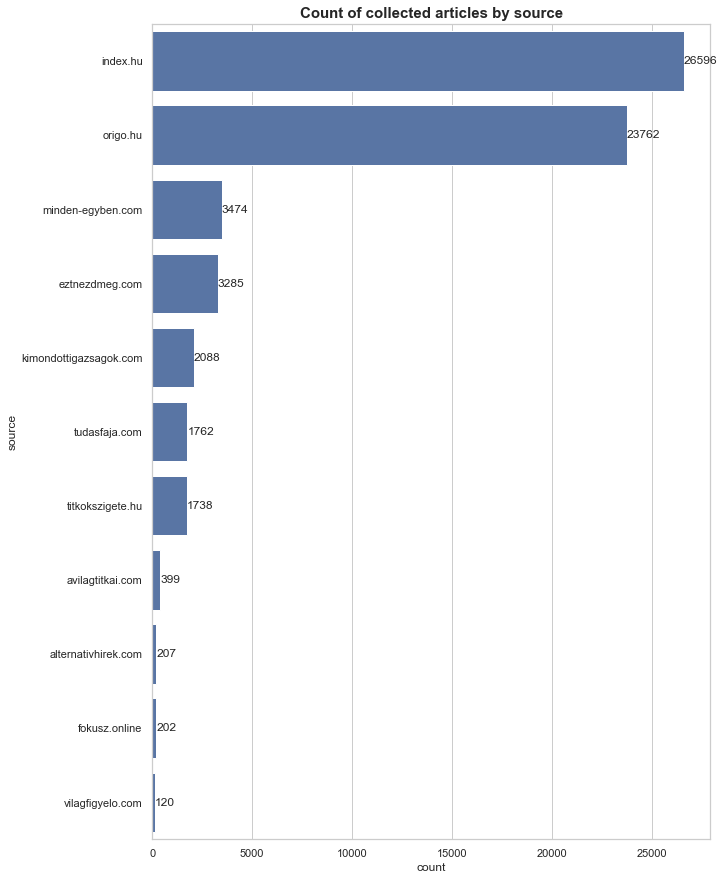

In [21]:
f, ax = plt.subplots(figsize=(10, 15))

sns.barplot(x="text", y="source", data=df_count,
            label="sources", color="b", order=plot_order)

plt.title('Count of collected articles by source', fontweight='bold', fontsize=15)
plt.xlabel('count', fontsize=12)
plt.ylabel('source', fontsize=12)

for p in ax.patches:
    width = p.get_width()   
    ax.text(width + 1,       
            p.get_y() + p.get_height() / 2, 
            '{:1.0f}'.format(width), 
            ha = 'left',   
            va = 'center') 

### 5. Feature engineering

### 5.1 Extract information from the title 

#### 5.1.1 Word count of the titles

In [48]:
abt_covid['title_word_cnt'] = abt_covid.title.apply(lambda x: len(str(x).split(" "))) 
abt_covid[['title', 'title_word_cnt']][0:2]

,title,title_word_cnt
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,5
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,8


#### 5.1.2 Average word length of the title

In [49]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

abt_covid['title_avg_word'] = abt_covid['title'].apply(lambda x: avg_word(x))
abt_covid[['title', 'title_avg_word']][0:2]

,title,title_avg_word
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,8.800
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,7.125


#### 5.1.3 Count of exclamation mark in the title

In [50]:
abt_covid['title_exclam_num'] = abt_covid['title'].str.count('\\!')
abt_covid[['title', 'title_exclam_num']].sort_values(by=["title_exclam_num"], ascending=False)[0:2]

,title,title_exclam_num
"""1200""",FONTOS!!! TUDJON RÓLA! VESZÉLY!!!! Tombol a já...,11
"""6673""",Figyelem! Most érkezett!!! ITT VAN A KANYARÓ B...,10


#### 5.1.4 Count of question mark in the title

In [51]:
abt_covid['title_ques_num'] = abt_covid['title'].str.count('\\?')
abt_covid[['title', 'title_ques_num']].sort_values(by=["title_ques_num"], ascending=False)[0:2]

,title,title_ques_num
"""2604""",KISZIVÁRGOTT!!! Jön a nagy bejelentés? TÉNYLEG...,5
"""2535""",NEE!!Ez egy agyrém! Erre kérik az iskolás korú...,4


#### 5.1.5 Count of stop words in the title

In [52]:
abt_covid['title_stop_cnt'] = abt_covid['title'].apply(lambda x: len([x for x in x.split() if x in stop]))
abt_covid[['title', 'title_stop_cnt']].head(3)

,title,title_stop_cnt
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,0
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,2
"""132""",Kell-e rettegnünk az új kínai tüdőgyulladástól?,2


#### 5.1.6 Count of capital words in the title

In [53]:
abt_covid['title_cnt_upper'] = abt_covid.title.apply(lambda x: len([x for x in x.split() if x.isupper()]))
abt_covid[['title', 'title_cnt_upper']].sort_values(by=["title_cnt_upper"], ascending=False)[0:3]

,title,title_cnt_upper
"""2387""","Ma reggel jelentették be ,sok az új fertőzött ...",23
"""992""",ITT A ROSSZ HÍR! Koronavírus – ezekben a magya...,23
"""1340""",ÚJ ADAT! MOST JELENTETTÉK BE! EKKOR LEHET VÉGL...,21


#### 5.1.7 Count of numeric values in the title

In [70]:
abt_covid['title_cnt_num'] = abt_covid['title'].str.count('[0-9]')
abt_covid[['title', 'title_cnt_num', 'source']].sort_values(by=["title_cnt_num"], ascending=False)[0:3]

,title,title_cnt_num,source
"""279""",Fizetés emelést kaptak a képviselők .Kövér Lás...,22,minden-egyben.com
"""2131""","Megszólalt a WHO: Lehet, hogy a vírus sosem ...",20,eztnezdmeg.com
"""17""","Megszólalt a WHO: Lehet, hogy a vírus sosem ...",20,eztnezdmeg.com


### 5.2 Extract information from the article

#### 5.2.1 Word count of the text

In [54]:
abt_covid['text_word_cnt'] = abt_covid.text.apply(lambda x: len(str(x).split(" "))) 
abt_covid[['text', 'text_word_cnt']][0:2]

,text,text_word_cnt
"""56""",A vpnMentor biztonságtechnikai kutatói 875 ez...,224
"""70""",Újabb kiberbiztonsági probléma Ukrajnában: a ...,172


#### 5.2.2 Average word length of the text

In [55]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

abt_covid['text_avg_word'] = abt_covid['text'].apply(lambda x: avg_word(x))
abt_covid[['text', 'text_avg_word']][0:2]

,text,text_avg_word
"""56""",A vpnMentor biztonságtechnikai kutatói 875 ez...,6.628959
"""70""",Újabb kiberbiztonsági probléma Ukrajnában: a ...,7.136095


#### 5.2.3 Count of question mark in the text

In [57]:
abt_covid['text_ques_num'] = abt_covid['text'].str.count('\\?')
abt_covid[['title', 'text_ques_num']].sort_values(by=["text_ques_num"], ascending=False)[0:2]

,title,text_ques_num
"""82037""",Most a nem létező negyedik hullámról terjeszt ...,202
"""71745""",A baloldal minden eszközzel megpróbálja elbizo...,129


#### 5.2.4 Count of exclamation mark in the text

In [58]:
abt_covid['text_exclam_num'] = abt_covid['text'].str.count('\\!')
abt_covid[['title', 'text_exclam_num']].sort_values(by=["text_exclam_num"], ascending=False)[0:2]

,title,text_exclam_num
"""82037""",Most a nem létező negyedik hullámról terjeszt ...,370
"""71745""",A baloldal minden eszközzel megpróbálja elbizo...,258


#### 5.2.5 Count of stop words in the text

In [59]:
abt_covid['text_stop_cnt'] = abt_covid['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
abt_covid[['title', 'text_stop_cnt']].head(3)

,title,text_stop_cnt
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,67
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,48
"""132""",Kell-e rettegnünk az új kínai tüdőgyulladástól?,439


#### 5.2.6 Count of capital words in the text

In [60]:
abt_covid['text_cnt_upper'] = abt_covid.text.apply(lambda x: len([x for x in x.split() if x.isupper()]))
abt_covid[['title', 'text_cnt_upper']].sort_values(by=["text_cnt_upper"], ascending=False)[0:3]

,title,text_cnt_upper
"""82037""",Most a nem létező negyedik hullámról terjeszt ...,900
"""71745""",A baloldal minden eszközzel megpróbálja elbizo...,820
"""89043""",Az oltásellenes baloldal újra az életmentő kel...,566


#### 5.2.7 Count of numeric values in the text

In [68]:
abt_covid['text_cnt_num'] = abt_covid['text'].str.count('[0-9]')
abt_covid[['title', 'text_cnt_num']].sort_values(by=["text_cnt_num"], ascending=False)[0:3]

,title,text_cnt_num
"""82037""",Most a nem létező negyedik hullámról terjeszt ...,7057
"""21550""","Motorozás közben videózta magát, belehalt az I...",6144
"""3068""",Gyász !33 évesen belehalt a covidba a híres te...,5702


Check for the newly created features

In [92]:
abt_covid.columns

Index(['title', 'date', 'text', 'source', 'dezinf', 'title_word_cnt',
       'title_avg_word', 'title_exclam_num', 'title_ques_num',
       'title_stop_cnt', 'title_cnt_upper', 'text_word_cnt', 'text_avg_word',
       'text_ques_num', 'text_exclam_num', 'text_stop_cnt', 'text_cnt_upper',
       'text_cnt_num', 'title_cnt_num', 'title_cleaned', 'text_cleaned',
       'title_tokens', 'text_tokens', 'title_lemmas', 'text_lemmas',
       'title_pos', 'text_pos', 'text_unique_lemma_ratio',
       'title_cnt_unique_lemmas', 'title_stop_word_ratio',
       'text_cnt_unique_lemmas', 'text_stop_word_ratio', 'title_noun_ratio',
       'title_verb_ratio', 'title_propn_ratio', 'title_adj_ratio',
       'text_noun_ratio', 'text_verb_ratio', 'text_propn_ratio',
       'text_adj_ratio'],
      dtype='object')

### 6. More data cleanings for the creation of NLP based variables
* lowercasing, 
* remove signs,
* remove stopwords, 
* remove numerical elements


In [64]:
def text_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    
    df['text_cleaned'] = df['text'].str.replace('-', ' ')
    df['text_cleaned'] = df['text_cleaned'].str.replace('[^\w\s]', ' ')
    df['text_cleaned'] = df['text_cleaned'].str.replace('\d+', ' ') 
    
    df['text_cleaned'] = df['text_cleaned'].str.lower()

    df['text_cleaned'] = df['text_cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    return df

In [65]:
def title_cleaning(df: pd.DataFrame) -> pd.DataFrame:

    df['title_cleaned'] = df['title'].str.replace('-', ' ')
    df['title_cleaned'] = df['title_cleaned'].str.replace('[^\w\s]', '')
    df['title_cleaned'] = df['title_cleaned'].str.replace('[0-9]', ' ')
    
    df['title_cleaned'] = df['title_cleaned'].str.lower()
    df['title_cleaned'] = df['title_cleaned'].str.replace('\xa0', ' ')

    df['title_cleaned'] = df['title_cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    return df

In [72]:
abt_covid = title_cleaning(abt_covid)

In [74]:
abt_covid = text_cleaning(abt_covid)

Check for the newly created features

In [75]:
abt_covid.columns

Index(['title', 'date', 'text', 'source', 'dezinf', 'title_word_cnt',
       'title_avg_word', 'title_exclam_num', 'title_ques_num',
       'title_stop_cnt', 'title_cnt_upper', 'text_word_cnt', 'text_avg_word',
       'text_ques_num', 'text_exclam_num', 'text_stop_cnt', 'text_cnt_upper',
       'text_cnt_num', 'title_cnt_num', 'title_cleaned', 'text_cleaned'],
      dtype='object')

### 7. Create NLP based features

### 7.1 Title tokenization

In [80]:
abt_covid["title_tokens"] = abt_covid["title_cleaned"].apply(lambda x: tknzr.tokenize(x))

In [82]:
abt_covid[['title','title_tokens']][0:2]

,title,title_tokens
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,"[szexstreamer, adatai, kerültek, nyilvánosságra]"
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,"[ukrán, állampolgárok, adatai, szivárogtak, ál..."


### 7.2 Text tokenization

In [83]:
abt_covid["text_tokens"] = abt_covid["text_cleaned"].apply(lambda x: tknzr.tokenize(x))

In [84]:
abt_covid[['text_cleaned','text_tokens']][0:2]

,text_cleaned,text_tokens
"""56""",vpnmentor biztonságtechnikai kutatói teljesen ...,"[vpnmentor, biztonságtechnikai, kutatói, telje..."
"""70""",kiberbiztonsági probléma ukrajnában nemzetbizt...,"[kiberbiztonsági, probléma, ukrajnában, nemzet..."


### 7.3 Title lemmatization

In [86]:
abt_covid['title_lemmas'] = abt_covid['title_cleaned'].apply(lambda x: [i.lemma_ for i in nlp(x)])

In [87]:
abt_covid[['title','title_tokens', 'title_lemmas']][0:2]

,title,title_tokens,title_lemmas
"""56""",4000 szexstreamer adatai kerültek nyilvánosságra,"[szexstreamer, adatai, kerültek, nyilvánosságra]","[szexstreamer, adat, kerül, nyilvánosság]"
"""70""",Ukrán állampolgárok adatai szivárogtak ki egy ...,"[ukrán, állampolgárok, adatai, szivárogtak, ál...","[ukrán, állampolgár, adat, szivárog, állami, w..."


### 7.4. Text lemmatization

In [88]:
abt_covid['text_lemmas'] = abt_covid['text_cleaned'].apply(lambda x: [i.lemma_ for i in nlp(x)])

In [89]:
abt_covid[['text_cleaned','text_tokens', 'text_lemmas']][0:2]

,text_cleaned,text_tokens,text_lemmas
"""56""",vpnmentor biztonságtechnikai kutatói teljesen ...,"[vpnmentor, biztonságtechnikai, kutatói, telje...","[vpnmentor, biztonságtechnikai, kutatói, telje..."
"""70""",kiberbiztonsági probléma ukrajnában nemzetbizt...,"[kiberbiztonsági, probléma, ukrajnában, nemzet...","[kiberbiztonsági, probléma, ukrajna, nemzetbiz..."


### 7.5 Part of Speach Tagging (PoS)

* count distinct lemmas
* count distinct lemmas / count all lemmas
* ADJ: adjective - melléknév
* ADV: adverb - határozószó
* AUX: auxiliary verb - segédige
* DET: determiner - határozószó
* NOUN: noun - főnév
* PRON: pronoun - névmás
* PROPN: proper noun - tulajdonnév
* VERB: verb - ige

#### 7.5.1 PoS on title

In [14]:
abt_covid['title_pos'] = abt_covid['title_cleaned'].apply(lambda x: [i.pos_ for i in nlp(x)])

In [11]:
abt_covid[['title_cleaned', 'title_lemmas', 'title_pos']][20:25]

,title_cleaned,title_lemmas,title_pos
"""646""",koronavírus magyarországon gyanús esetet vizsg...,"[koronavírus, magyarország, gyanús, eset, vizs...","[NOUN, ADJ, ADJ, NOUN, VERB]"
"""667""",hordanak szájmaszkot kínában győzi koronavírust,"[hord, szájmaszk, kína, győz, koronavírus]","[VERB, NOUN, NOUN, VERB, NOUN]"
"""672""",koronavírus kínában ezrek fertőződhettek usa e...,"[koronavírus, kína, ezrek, fertőződik, usa, ev...","[NOUN, NOUN, ADV, VERB, ADV, VERB, VERB, ADJ, ..."
"""678""",kínait kórházba vinni moszkvai szállodából,"[kín, kórház, vinni, moszkvai, szálloda]","[NOUN, NOUN, ADJ, ADJ, NOUN]"
"""683""",mennyire képben legfontosabb történéseivel,"[mennyire, kép, fontos, történés]","[ADV, NOUN, ADJ, NOUN]"


#### 7.5.2 PoS on text

In [17]:
abt_covid['text_pos'] = abt_covid['text_cleaned'].apply(lambda x: [i.pos_ for i in nlp(x)])

In [12]:
abt_covid[['text_cleaned', 'text_lemmas', 'title_pos']][20:25]

,text_cleaned,text_lemmas,title_pos
"""646""",továbbra sincs magyar érintettje kínából kiind...,"[továbbra, sincs, magyar, érintett, kíon, kiin...","[NOUN, ADJ, ADJ, NOUN, VERB]"
"""667""",kínai hatóságok kérték vuhan lakóit hordjanak ...,"[kínai, hatóság, kér, vuhan, lakó, hordik, orv...","[VERB, NOUN, NOUN, VERB, NOUN]"
"""672""",friss országos tisztifőorvos közlése tudomásuk...,"[friss, országos, tisztifőorvos, közlés, tudom...","[NOUN, NOUN, ADV, VERB, ADV, VERB, VERB, ADJ, ..."
"""678""",kínai vendég pihen volkovszkaja szállóban oros...,"[kínai, vendég, pihen, volkovszkaja, szálló, o...","[NOUN, NOUN, ADJ, ADJ, NOUN]"
"""683""",hallott schobert norbi ámokfutásáról borkai sz...,"[hall, schobert, norbi, ámokfutás, borkai, sze...","[ADV, NOUN, ADJ, NOUN]"


### 7.6 Create normalized features

The rate of distinct lemmas in the article text. 

In [49]:
abt_covid["text_unique_lemma_ratio"] = abt_covid["text_lemmas"].apply(lambda x: len(np.unique(x)) / len(x))

The rate of stop words in the article title

In [55]:
abt_covid["title_cnt_unique_lemmas"] = abt_covid["title_lemmas"].apply(lambda x: len(np.unique(x)))s

In [58]:
abt_covid["title_stop_word_ratio"] = abt_covid["title_stop_cnt"] / abt_covid["title_cnt_unique_lemmas"]

The rate of stop words in the article text

In [60]:
abt_covid["text_cnt_unique_lemmas"] = abt_covid["text_lemmas"].apply(lambda x: len(np.unique(x)))

In [62]:
abt_covid["text_stop_word_ratio"] = abt_covid["text_stop_cnt"] / abt_covid["text_cnt_unique_lemmas"]

The rate of nouns in the article title

In [71]:
abt_covid["title_noun_ratio"] = abt_covid["title_pos"].apply(lambda x: x.count("NOUN") / len(x) if x.count("NOUN") > 0 else 0)

The rate of verbs in the article title

In [72]:
abt_covid["title_verb_ratio"] = abt_covid["title_pos"].apply(lambda x: x.count("VERB") / len(x) if x.count("VERB") > 0 else 0)

The rate of PROPNs in the article title

In [74]:
abt_covid["title_propn_ratio"] = abt_covid["title_pos"].apply(lambda x: x.count("PROPN") / len(x) if x.count("PROPN") > 0 else 0)

The rate of adjs in the article title

In [77]:
abt_covid["title_adj_ratio"] = abt_covid["title_pos"].apply(lambda x: x.count("ADJ") / len(x) if x.count("ADJ") > 0 else 0)

The rate of nouns in the article text

In [83]:
abt_covid["text_noun_ratio"] = abt_covid["text_pos"].apply(lambda x: x.count("NOUN") / len(x) if x.count("NOUN") > 0 else 0)

The rate of verbs in the article text

In [84]:
abt_covid["text_verb_ratio"] = abt_covid["text_pos"].apply(lambda x: x.count("VERB") / len(x) if x.count("VERB") > 0 else 0)

The rate of PROPNs in the article text

In [86]:
abt_covid["text_propn_ratio"] = abt_covid["text_pos"].apply(lambda x: x.count("PROPN") / len(x) if x.count("PROPN") > 0 else 0)

The rate of adjs in the article text

In [88]:
abt_covid["text_adj_ratio"] = abt_covid["text_pos"].apply(lambda x: x.count("ADJ") / len(x) if x.count("ADJ") > 0 else 0)

###  8. Check the list of created features

In [90]:
abt_covid.columns

Index(['title', 'date', 'text', 'source', 'dezinf', 'title_word_cnt',
       'title_avg_word', 'title_exclam_num', 'title_ques_num',
       'title_stop_cnt', 'title_cnt_upper', 'text_word_cnt', 'text_avg_word',
       'text_ques_num', 'text_exclam_num', 'text_stop_cnt', 'text_cnt_upper',
       'text_cnt_num', 'title_cnt_num', 'title_cleaned', 'text_cleaned',
       'title_tokens', 'text_tokens', 'title_lemmas', 'text_lemmas',
       'title_pos', 'text_pos', 'text_unique_lemma_ratio',
       'title_cnt_unique_lemmas', 'title_stop_word_ratio',
       'text_cnt_unique_lemmas', 'text_stop_word_ratio', 'title_noun_ratio',
       'title_verb_ratio', 'title_propn_ratio', 'title_adj_ratio',
       'text_noun_ratio', 'text_verb_ratio', 'text_propn_ratio',
       'text_adj_ratio'],
      dtype='object')

### 9. Named Entity Recognition (Ner)

### 9.1 Create the NER dictionary for the titles

In [95]:
dic = {}
lis = []
for i in abt_covid["title"]:
    token = []
    entit = []
    doc = nlp(i)
    for ent in doc.ents:
        token.append(ent.text)
        entit.append(ent.label_)
    dic = dict(zip(token, entit))
    lis.append(dic)

#### 9.1.1 Create the Person list for each document

In [100]:
per_list = []
for i in range(0, len(lis)):
    per_ent = {key:value for (key, value) in lis[i].items() if value == 'PER'}
    per_ent = list(per_ent.keys())
    
    per_list.append(per_ent)

In [104]:
abt_covid["title_ner_pers"] = per_list

#### 9.1.2 Create the Organization list for each document

In [105]:
org_list = []
for i in range(0, len(lis)):
    org_ent = {key:value for (key, value) in lis[i].items() if value == 'ORG'}
    org_ent = list(org_ent.keys())
    
    org_list.append(org_ent)

In [107]:
abt_covid["title_ner_orgs"] = org_list

#### 9.1.3 Create the Location list for each document

In [108]:
loc_list = []
for i in range(0, len(lis)):
    loc_ent = {key:value for (key, value) in lis[i].items() if value == 'LOC'}
    loc_ent = list(loc_ent.keys())
    
    loc_list.append(loc_ent)

In [109]:
abt_covid["title_ner_locs"] = loc_list

### 9.2 Create the NER dictionary for the texts


In [112]:
dic = {}
lis = []
for i in abt_covid["text"]:
    token = []
    entit = []
    doc = nlp(i)
    for ent in doc.ents:
        token.append(ent.text)
        entit.append(ent.label_)
    dic = dict(zip(token, entit))
    lis.append(dic)

#### 9.2.1 Create the Person list for each document

In [114]:
per_list = []
for i in range(0, len(lis)):
    per_ent = {key:value for (key, value) in lis[i].items() if value == 'PER'}
    per_ent = list(per_ent.keys())
    
    per_list.append(per_ent)

In [116]:
abt_covid["text_ner_pers"] = per_list

#### 9.2.2 Create the Organization list for each document

In [118]:
org_list = []
for i in range(0, len(lis)):
    org_ent = {key:value for (key, value) in lis[i].items() if value == 'ORG'}
    org_ent = list(org_ent.keys())
    
    org_list.append(org_ent)

In [119]:
abt_covid["text_ner_orgs"] = org_list

#### 9.2.3 Create the Location list for each document

In [121]:
loc_list = []
for i in range(0, len(lis)):
    loc_ent = {key:value for (key, value) in lis[i].items() if value == 'LOC'}
    loc_ent = list(loc_ent.keys())
    
    loc_list.append(loc_ent)

In [122]:
abt_covid["text_ner_locs"] = loc_list

### 10. Sentiment Analysis

#### 10.1 Polarity Analysis

The sentiment polarization function iterates through the document lemmas. If the lemma in negative word dictionary it returns with -1, if the lemma in the positive word dictionary it returns with 1. If the lemma not in the positive and negative dictionary, the lemma is neutral, so it returns with 0. I will apply the sentiment_polarizer function on title and text.

In [16]:
def sentiment_polarizer(df):
    sent = []
    for i in range(0, len(df)):
        if str(df[i]) in pos: 
            sent.append(1)
        elif str(df[i]) in neg: 
            sent.append(-1)
        else:
            sent.append(0)
    return sent

In [22]:
def polariser(senti_list):
    
    if sum(senti_list) > 0:
        polarity = sum(senti_list) / len(senti_list)
    else:
        polarity = 0
        
    return polarity

#### 10.1.1 Polarity analysis on title lemmas

In [17]:
abt_covid["title_senti_list"] = abt_covid["title_lemmas"].apply(lambda x: sentiment_polarizer(x))

In [23]:
abt_covid["title_polarity"] = abt_covid["title_senti_list"].apply(lambda x: polariser(x))

In [31]:
abt_covid[abt_covid["title_polarity"] > 0].sort_values(by=["title_polarity"], ascending = False).head(2)

,title,date,text,source,dezinf,title_word_cnt,title_avg_word,title_exclam_num,title_ques_num,title_stop_cnt,...,text_propn_ratio,text_adj_ratio,title_ner_pers,title_ner_orgs,title_ner_locs,text_ner_pers,text_ner_orgs,text_ner_locs,title_senti_list,title_polarity
"""21273""","A megbízhatóság, a stabilitás nagyon fontos",2020.06.25. 08:07,"Hollik István, a KDNP országgyűlési képviselőj...",origo.hu,0,6,6.333333,0,0,2,...,0.0,0.280000,[],[],[],"[Hollik István, Karácsony Gergely]","[KDNP, Fidesz, Heti Tv Pirkadat, Lánchíd, Fővá...","[Lánchídról, Magyarország]","[1, 1, 1]",1.0
"""5575""","Nem vagyok szakember, de...",2020-04-01,"2020 van, közhely, hogy sokaknak a közösségi ...",index.hu,0,4,6.000000,0,0,1,...,0.0,0.244318,[],[],[],[Müller Viktor],"[Indexnek, ELTE Biológiai Intézetének, Index]",[],[1],1.0


#### 10.1.2 Polarity analysis on text lemmas

In [32]:
abt_covid["text_senti_list"] = abt_covid["text_lemmas"].apply(lambda x: sentiment_polarizer(x))

In [34]:
abt_covid["text_polarity"] = abt_covid["text_senti_list"].apply(lambda x: polariser(x))

In [38]:
abt_covid[abt_covid["text_polarity"] > 0].sort_values(by=["text_polarity"], ascending = False).head(5)

,title,date,text,source,dezinf,title_word_cnt,title_avg_word,title_exclam_num,title_ques_num,title_stop_cnt,...,title_ner_pers,title_ner_orgs,title_ner_locs,text_ner_pers,text_ner_orgs,text_ner_locs,title_senti_list,title_polarity,text_senti_list,text_polarity
"""77461""",Orbán Viktor: Köszönjük!,2021.06.05. 20:20,A magyar kormányfő a közösségi oldalán közzéte...,origo.hu,0,3,7.333333,1,0,0,...,"[Orbán Viktor, Köszönjük]",[],[],[],[],[],"[0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...",0.222222
"""586""",Hétfőn érkeznek meg kórházparancsnokok a kór...,2020-03-29,Hétfőtől kórházparancsnokok segítik a kórháza...,eztnezdmeg.com,1,8,7.666667,0,0,2,...,[],[],[],[],[],[],"[0, 0, 0, 0]",0.0,"[0, 0, 1, 0, 0]",0.200000
"""586""",Hétfőn érkeznek meg kórházparancsnokok a kór...,2020-03-29,Hétfőtől kórházparancsnokok segítik a kórháza...,eztnezdmeg.com,1,8,7.666667,0,0,2,...,[],[],[],[],[],[],"[0, 0, 0, 0]",0.0,"[0, 0, 1, 0, 0]",0.200000
"""3878""",Hétfőn érkeznek meg kórházparancsnokok a kór...,2020-03-29,Hétfőtől kórházparancsnokok segítik a kórháza...,eztnezdmeg.com,1,8,7.666667,0,0,2,...,[],[],[],[],[],[],"[0, 0, 0, 0]",0.0,"[0, 0, 1, 0, 0]",0.200000
"""1280""","Ember száját nem hagyta még el olyan igazság, ...",2021.ápr.02.,"Juszt László értelmes, őszinte ember. Úgy láts...",minden-egyben.com,1,23,5.000000,0,0,9,...,"[Ember, Juszt László]",[],[MindenegybenBlog],[Juszt László],[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0]",0.200000


### 11. Difference from global mean variables

In [55]:
title_num_cols_list = ['title_word_cnt', 'title_avg_word', 'title_exclam_num', 'title_ques_num',
                       'title_stop_cnt', 'title_cnt_upper', 'title_cnt_num', 'title_cnt_unique_lemmas',
                       'title_stop_word_ratio', 'title_verb_ratio', 'title_propn_ratio', 'title_adj_ratio',
                       'title_polarity']

In [56]:
text_num_cols_list = ['text_word_cnt', 'text_avg_word', 'text_exclam_num', 'text_ques_num',
                      'text_stop_cnt', 'text_cnt_upper', 'text_cnt_num', 'text_unique_lemma_ratio',
                      'text_cnt_unique_lemmas', 'text_stop_word_ratio', 'text_noun_ratio',
                      'text_verb_ratio', 'text_propn_ratio', 'text_adj_ratio']

In [69]:
df_title_diffs = pd.DataFrame()

for x, y in combinations(title_num_cols_list, 2):
    
    df_title_diffs['DIFF_'+ x] = abt_covid[i].sub(abt_covid[x].mean())

In [70]:
df_title_diffs

,DIFF_title_word_cnt,DIFF_title_avg_word,DIFF_title_exclam_num,DIFF_title_ques_num,DIFF_title_stop_cnt,DIFF_title_cnt_upper,DIFF_title_cnt_num,DIFF_title_cnt_unique_lemmas,DIFF_title_stop_word_ratio,DIFF_title_verb_ratio,DIFF_title_propn_ratio,DIFF_title_adj_ratio
"""56""",-4.575097,-1.577606,4.851173,4.945624,2.408637,4.617592,4.577061,-1.032641,4.5405,4.826341,4.999497,4.766837
"""70""",-1.575097,1.422394,7.851173,7.945624,5.408637,7.617592,7.577061,1.967359,7.5405,7.826341,7.999497,7.766837
"""132""",-3.575097,-0.577606,5.851173,5.945624,3.408637,5.617592,5.577061,-0.032641,5.5405,5.826341,5.999497,5.766837
"""135""",-0.575097,2.422394,8.851173,8.945624,6.408637,8.617592,8.577061,2.967359,8.5405,8.826341,8.999497,8.766837
"""141""",-0.575097,2.422394,8.851173,8.945624,6.408637,8.617592,8.577061,2.967359,8.5405,8.826341,8.999497,8.766837
...,...,...,...,...,...,...,...,...,...,...,...,...
"""7242""",6.424903,9.422394,15.851173,15.945624,13.408637,15.617592,15.577061,9.967359,15.5405,15.826341,15.999497,15.766837
"""7246""",25.424903,28.422394,34.851173,34.945624,32.408637,34.617592,34.577061,28.967359,34.5405,34.826341,34.999497,34.766837
"""7261""",4.424903,7.422394,13.851173,13.945624,11.408637,13.617592,13.577061,7.967359,13.5405,13.826341,13.999497,13.766837
"""7263""",17.424903,20.422394,26.851173,26.945624,24.408637,26.617592,26.577061,20.967359,26.5405,26.826341,26.999497,26.766837


In [71]:
df_text_diffs = pd.DataFrame()

for x, y in combinations(text_num_cols_list, 2):
    
    df_text_diffs['DIFF_'+ x] = abt_covid[i].sub(abt_covid[x].mean())

In [72]:
df_text_diffs

,DIFF_text_word_cnt,DIFF_text_avg_word,DIFF_text_exclam_num,DIFF_text_ques_num,DIFF_text_stop_cnt,DIFF_text_cnt_upper,DIFF_text_cnt_num,DIFF_text_unique_lemma_ratio,DIFF_text_cnt_unique_lemmas,DIFF_text_stop_word_ratio,DIFF_text_noun_ratio,DIFF_text_verb_ratio,DIFF_text_propn_ratio
"""56""",-381.124672,-1.537217,4.559759,4.495277,-119.823404,-2.871918,-27.166695,4.227457,-158.618928,4.311263,4.486201,4.852052,4.998503
"""70""",-378.124672,1.462783,7.559759,7.495277,-116.823404,0.128082,-24.166695,7.227457,-155.618928,7.311263,7.486201,7.852052,7.998503
"""132""",-380.124672,-0.537217,5.559759,5.495277,-118.823404,-1.871918,-26.166695,5.227457,-157.618928,5.311263,5.486201,5.852052,5.998503
"""135""",-377.124672,2.462783,8.559759,8.495277,-115.823404,1.128082,-23.166695,8.227457,-154.618928,8.311263,8.486201,8.852052,8.998503
"""141""",-377.124672,2.462783,8.559759,8.495277,-115.823404,1.128082,-23.166695,8.227457,-154.618928,8.311263,8.486201,8.852052,8.998503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"""7242""",-370.124672,9.462783,15.559759,15.495277,-108.823404,8.128082,-16.166695,15.227457,-147.618928,15.311263,15.486201,15.852052,15.998503
"""7246""",-351.124672,28.462783,34.559759,34.495277,-89.823404,27.128082,2.833305,34.227457,-128.618928,34.311263,34.486201,34.852052,34.998503
"""7261""",-372.124672,7.462783,13.559759,13.495277,-110.823404,6.128082,-18.166695,13.227457,-149.618928,13.311263,13.486201,13.852052,13.998503
"""7263""",-359.124672,20.462783,26.559759,26.495277,-97.823404,19.128082,-5.166695,26.227457,-136.618928,26.311263,26.486201,26.852052,26.998503


In [75]:
abt_covid = pd.concat([abt_covid, df_title_diffs, df_text_diffs], axis=1)

### 12. Save the created dataframe 

In [77]:
abt_covid.columns

Index(['title', 'date', 'text', 'source', 'dezinf', 'title_word_cnt',
       'title_avg_word', 'title_exclam_num', 'title_ques_num',
       'title_stop_cnt', 'title_cnt_upper', 'text_word_cnt', 'text_avg_word',
       'text_ques_num', 'text_exclam_num', 'text_stop_cnt', 'text_cnt_upper',
       'text_cnt_num', 'title_cnt_num', 'title_cleaned', 'text_cleaned',
       'title_tokens', 'text_tokens', 'title_lemmas', 'text_lemmas',
       'title_pos', 'text_pos', 'text_unique_lemma_ratio',
       'title_cnt_unique_lemmas', 'title_stop_word_ratio',
       'text_cnt_unique_lemmas', 'text_stop_word_ratio', 'title_noun_ratio',
       'title_verb_ratio', 'title_propn_ratio', 'title_adj_ratio',
       'text_noun_ratio', 'text_verb_ratio', 'text_propn_ratio',
       'text_adj_ratio', 'title_ner_pers', 'title_ner_orgs', 'title_ner_locs',
       'text_ner_pers', 'text_ner_orgs', 'text_ner_locs', 'title_senti_list',
       'title_polarity', 'text_senti_list', 'text_polarity',
       'DIFF_title_word_

In [78]:
abt_covid.to_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')